In [85]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from requests import get
from bs4 import BeautifulSoup
import folium
from sklearn import preprocessing
import geopandas as gpd
import matplotlib.colors as colors
import matplotlib.colors as colors
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from helpers import *
from ipywidgets import SelectMultiple, RadioButtons, interact
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
en='environment/'
cl='crops_and_livestock/'
BB='Burning_biomass.csv'
EAT='Emissions_Agriculture_Agriculture_total_E_All_Data_NOFLAG.csv'
EI='Emissions_intensities.csv'
EESAD='Environment_Emissions_by_Sector_E_All_Data_(Normalized).csv'
FA='Fertilizers_archive.csv'
FN='Fertilizers_nutrient.csv'
FP='Fertilizers_product.csv'
LU='Land_use.csv'
LU2='Land_use_2.csv'
PU='Pesticides_use.csv'
PC='Production_Crops_E_All_Data_NOFLAG.csv'
TC='Temperature_change.csv'

In [3]:
world_df = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
countries = set(world_df['name'])

## Abstract
We are going to focus our anlysis from year 2000 to 2017

# Agriculture data
We start our analysis from the agriculture and livestock datasets.

In [4]:
# Loading the DataSet
crops = pd.read_csv(cl+PC, encoding = "ISO-8859-1")

In [5]:
# See how the data is organized
crops.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
0,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,ha,NaN,NaN,NaN,...,12000.0,11029.0,11210.0,13469.0,13490.0,14114.0,13703.0,14676.0,19481.0,19793.0
1,2,Afghanistan,221,"Almonds, with shell",5419,Yield,hg/ha,NaN,NaN,NaN,...,35000.0,39154.0,49955.0,45000.0,45960.0,29910.0,19996.0,16521.0,16859.0,13788.0
2,2,Afghanistan,221,"Almonds, with shell",5510,Production,tonnes,NaN,NaN,NaN,...,42000.0,43183.0,56000.0,60611.0,62000.0,42215.0,27400.0,24246.0,32843.0,27291.0
3,2,Afghanistan,711,"Anise, badian, fennel, coriander",5312,Area harvested,ha,NaN,NaN,NaN,...,15000.0,17748.0,17000.0,19500.0,18500.0,18500.0,30000.0,25000.0,26019.0,28873.0
4,2,Afghanistan,711,"Anise, badian, fennel, coriander",5419,Yield,hg/ha,NaN,NaN,NaN,...,6000.0,6203.0,6000.0,6414.0,6757.0,6757.0,7167.0,7200.0,6923.0,6830.0


We now create a function to get all the unique values from the columns Item, Element and Unit in order to better understand what data is contained in the dataset.

In [6]:
def uniquevalues(df):
    for i in ['Item', 'Element', 'Unit', 'Area']:
        print(i)
        print(df[i].unique())

In [7]:
uniquevalues(crops)

Item
['Almonds, with shell' 'Anise, badian, fennel, coriander' 'Apples'
 'Apricots' 'Barley' 'Berries nes' 'Cotton lint' 'Cottonseed' 'Figs'
 'Fruit, citrus nes' 'Fruit, fresh nes' 'Fruit, stone nes' 'Grapes'
 'Linseed' 'Maize' 'Melons, other (inc.cantaloupes)' 'Millet' 'Nuts, nes'
 'Olives' 'Onions, dry' 'Oranges' 'Peaches and nectarines' 'Pears'
 'Pistachios' 'Plums and sloes' 'Potatoes' 'Pulses, nes' 'Rice, paddy'
 'Seed cotton' 'Sesame seed' 'Spices, nes' 'Sugar beet' 'Sugar cane'
 'Sunflower seed' 'Vegetables, fresh nes' 'Walnuts, with shell'
 'Watermelons' 'Wheat' 'Cereals (Rice Milled Eqv)' 'Cereals,Total'
 'Citrus Fruit,Total' 'Coarse Grain, Total' 'Fibre Crops Primary'
 'Fruit Primary' 'Oilcrops, Cake Equivalent' 'Oilcrops, Oil Equivalent'
 'Pulses,Total' 'Roots and Tubers,Total' 'Treenuts,Total'
 'Vegetables Primary' 'Beans, dry' 'Beans, green'
 'Broad beans, horse beans, dry' 'Cabbages and other brassicas'
 'Carrots and turnips' 'Cauliflowers and broccoli' 'Cherries'
 'Cherr

As we can see, in the Item column, the kind of vegetable or fruit condsidered is reported. In the Element columns we have instead either the harvested area, the amount produced or the yield which is the harvested production per unit of harvested area for all the crop products.

For each Element there is a different unit parameter (as stated in the FAO website): 
- Production : tonnes
- Area harvested: hectares
- Yield: tonnes per hectare.

We decided to keep only Production, this beacuse this feature is the more significant for the purpose of the project in general. **we are probably going to consider the *Area harvest* when we will talk about the energy source consuption**

In [8]:
# Save the data in a new DF and see the result
crops_production = crops[crops['Element']=='Production']
crops_production.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
2,2,Afghanistan,221,"Almonds, with shell",5510,Production,tonnes,NaN,NaN,NaN,...,42000.0,43183.0,56000.0,60611.0,62000.0,42215.0,27400.0,24246.0,32843.0,27291.0
5,2,Afghanistan,711,"Anise, badian, fennel, coriander",5510,Production,tonnes,NaN,NaN,NaN,...,9000.0,11008.0,10200.0,12508.0,12500.0,12500.0,21500.0,18000.0,18012.0,19719.0
8,2,Afghanistan,515,Apples,5510,Production,tonnes,15100.0,15100.0,15100.0,...,56061.0,72765.0,59850.0,62041.0,70000.0,78597.0,89403.0,89733.0,140903.0,175000.0
11,2,Afghanistan,526,Apricots,5510,Production,tonnes,32000.0,32000.0,32000.0,...,59559.0,60000.0,66560.0,67995.0,83500.0,90000.0,90000.0,87686.0,17894.0,131816.0
14,2,Afghanistan,44,Barley,5510,Production,tonnes,378000.0,378000.0,378000.0,...,333000.0,486000.0,437000.0,305900.0,504000.0,514000.0,521000.0,403000.0,301856.0,94995.0


In [9]:
# Check that we have a unique unit now
crops_production.Element.unique()

array(['Production'], dtype=object)

As already mentioned, we are going to focus our analysis on the time interval between 2000 and 2017, therefore we need to drop the columns until 1999.

In [10]:
# Define teh columns years we need to drop and drop them
years = ['Y'+str(1900+x) for x in range(61,100)]
crops_production = crops_production.drop(years, axis=1)

In [11]:
# Check teh result
crops_production.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y2000,Y2001,Y2002,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
2,2,Afghanistan,221,"Almonds, with shell",5510,Production,tonnes,12000.0,15000.0,11774.0,...,42000.0,43183.0,56000.0,60611.0,62000.0,42215.0,27400.0,24246.0,32843.0,27291.0
5,2,Afghanistan,711,"Anise, badian, fennel, coriander",5510,Production,tonnes,2500.0,1000.0,2000.0,...,9000.0,11008.0,10200.0,12508.0,12500.0,12500.0,21500.0,18000.0,18012.0,19719.0
8,2,Afghanistan,515,Apples,5510,Production,tonnes,40540.0,39542.0,35630.0,...,56061.0,72765.0,59850.0,62041.0,70000.0,78597.0,89403.0,89733.0,140903.0,175000.0
11,2,Afghanistan,526,Apricots,5510,Production,tonnes,42840.0,38000.0,45758.0,...,59559.0,60000.0,66560.0,67995.0,83500.0,90000.0,90000.0,87686.0,17894.0,131816.0
14,2,Afghanistan,44,Barley,5510,Production,tonnes,74000.0,87000.0,345000.0,...,333000.0,486000.0,437000.0,305900.0,504000.0,514000.0,521000.0,403000.0,301856.0,94995.0


Considering the Area column we can see that there are rows that actually represent a region and not a specific Country. We want to drop these columns.
<br>
There are also some countries that have changed over time such as Sudan that is classified as Sudan and Sudan(former). We want to collect the data and refer it to a unique country.
<br>
Since the ultimate goal is to obtain a colormap of the world, we use the GeoPandas package. We then change the names of all the countries that have different names from the ones used by GeoPandas (e.g. 'Bosnia and Herzegovina' is replaced by 'Bosnia and Herz.').

In [12]:
changes = {'Area' : { 'Bosnia and Herzegovina' : 'Bosnia and Herz.' ,
                    'Brunei Darussalam' : 'Brunei',
                    "Czechoslovakia" : "Czechia",
                    "Republic of Korea" : 'South Korea',
                    "Democratic People's Republic of Korea" : 'North Korea',
                    "Democratic Republic of the Congo" : 'Dem. Rep. Congo',
                    "Bolivia (Plurinational State of)" : 'Bolivia',
                    "Venezuela (Bolivarian Republic of)" : 'Venezuela',
                    "Republic of Moldova" : 'Moldova',
                     "Dominican Republic" : 'Dominican Rep.',
                     "Equatorial Guinea" : "Eq. Guinea",
                     "Eswatini" : "eSwatini",
                     "Ethiopia PDR" : "Ethiopia",
                     "Iran (Islamic Republic of)":"Iran",
                     "Serbia and Montenegro" : "Serbia",
                     "Sudan (former)" : "Sudan",
                     "South Sudan" : "S. Sudan",
                     "Syrian Arab Republic":"Syria",
                     "The former Yugoslav Republic of Macedonia":"Macedonia",
                     "United Republic of Tanzania":"Tanzania",
                     "Viet Nam": "Vietnam",
                     'Russian Federation':"Russia",
                     'Central African Republic' :'Central African Rep.',
                     'USSR':'Russia'
                    }}

In [13]:
crops_production = crops_production.replace(changes)

Since all the production is reported in terms of tonnes, at a first approximation we can report the total production of all the products. Therefore we groupby the Area and sum the values.

In [14]:
# Calculate the total production
crops_production = crops_production.groupby('Area').sum()
to_drop = ['Area Code','Item Code','Element Code']
crops_production = crops_production.drop(to_drop, axis=1)

In [15]:
# Check the result
crops_production.head()

,Y2000,Y2001,Y2002,Y2003,Y2004,Y2005,Y2006,Y2007,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
Area,,,,,,,,,,,,,,,,,,
Afghanistan,1.078967e+07,1.140639e+07,1.664507e+07,1.864147e+07,1.598002e+07,2.217056e+07,2.003394e+07,2.361243e+07,1.790652e+07,2.626508e+07,2.408772e+07,1.950941e+07,2.518499e+07,2.568590e+07,2.745402e+07,2.482097e+07,2.650892e+07,2.303543e+07
Africa,1.165958e+09,1.202676e+09,1.244143e+09,1.323296e+09,1.362229e+09,1.428736e+09,1.494014e+09,1.445043e+09,1.529804e+09,1.550891e+09,1.650939e+09,1.652144e+09,1.766952e+09,1.823900e+09,1.912913e+09,1.890117e+09,1.913682e+09,1.976643e+09
Albania,3.957659e+06,3.888688e+06,3.936028e+06,3.892278e+06,4.006107e+06,4.102620e+06,4.195227e+06,4.122909e+06,4.743277e+06,4.971402e+06,5.599074e+06,5.867007e+06,6.005984e+06,6.015630e+06,6.104135e+06,6.284231e+06,6.549896e+06,6.611361e+06
Algeria,1.431067e+07,2.042880e+07,1.964556e+07,3.022625e+07,3.122427e+07,3.121469e+07,3.390482e+07,3.016654e+07,2.577084e+07,4.272033e+07,4.222562e+07,4.565594e+07,5.040224e+07,5.389180e+07,4.620347e+07,4.844512e+07,4.824687e+07,4.883251e+07
American Samoa,2.290600e+04,2.639900e+04,2.783900e+04,3.160100e+04,3.061900e+04,3.182600e+04,3.250700e+04,3.313500e+04,3.387900e+04,3.487200e+04,3.542200e+04,3.501700e+04,3.380500e+04,3.663800e+04,3.630200e+04,3.594900e+04,3.611000e+04,3.662300e+04


Considering the Area column we can see that there are rows that actually represent a region and not a specific Country. We want to drop these columns.
<br>
There are also some countries that have changed over time such as Sudan that is classified as Sudan and Sudan(former). We want to collect the data and refer it to a unique country.
<br>
Since the ultimate goal is to obtain a colormap of the world, we use the GeoPandas package. We then change the names of all the countries that have different names from the ones used by GeoPandas (e.g. 'Bosnia and Herzegovina' is replaced by 'Bosnia and Herz.').

In [16]:
crops_production.head()

,Y2000,Y2001,Y2002,Y2003,Y2004,Y2005,Y2006,Y2007,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
Area,,,,,,,,,,,,,,,,,,
Afghanistan,1.078967e+07,1.140639e+07,1.664507e+07,1.864147e+07,1.598002e+07,2.217056e+07,2.003394e+07,2.361243e+07,1.790652e+07,2.626508e+07,2.408772e+07,1.950941e+07,2.518499e+07,2.568590e+07,2.745402e+07,2.482097e+07,2.650892e+07,2.303543e+07
Africa,1.165958e+09,1.202676e+09,1.244143e+09,1.323296e+09,1.362229e+09,1.428736e+09,1.494014e+09,1.445043e+09,1.529804e+09,1.550891e+09,1.650939e+09,1.652144e+09,1.766952e+09,1.823900e+09,1.912913e+09,1.890117e+09,1.913682e+09,1.976643e+09
Albania,3.957659e+06,3.888688e+06,3.936028e+06,3.892278e+06,4.006107e+06,4.102620e+06,4.195227e+06,4.122909e+06,4.743277e+06,4.971402e+06,5.599074e+06,5.867007e+06,6.005984e+06,6.015630e+06,6.104135e+06,6.284231e+06,6.549896e+06,6.611361e+06
Algeria,1.431067e+07,2.042880e+07,1.964556e+07,3.022625e+07,3.122427e+07,3.121469e+07,3.390482e+07,3.016654e+07,2.577084e+07,4.272033e+07,4.222562e+07,4.565594e+07,5.040224e+07,5.389180e+07,4.620347e+07,4.844512e+07,4.824687e+07,4.883251e+07
American Samoa,2.290600e+04,2.639900e+04,2.783900e+04,3.160100e+04,3.061900e+04,3.182600e+04,3.250700e+04,3.313500e+04,3.387900e+04,3.487200e+04,3.542200e+04,3.501700e+04,3.380500e+04,3.663800e+04,3.630200e+04,3.594900e+04,3.611000e+04,3.662300e+04


Now we need to import the DataFrame of the package GeoPandas. In these DF we can find all the information related to country and choromap.

In [17]:
# Import the list of all the countries and drop the regions
world_df = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
countries = set(world_df['name'])

In the FAO's Datasets we have several information related to areas which are not state (e.g.'Europe'). Right now we don't need this information so drop those columns.

In [18]:
to_delete = set(crops_production.index).difference(countries)
crops_production = crops_production.drop(to_delete, axis=0)

In [19]:
# Check the result
crops_production.head()

,Y2000,Y2001,Y2002,Y2003,Y2004,Y2005,Y2006,Y2007,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
Area,,,,,,,,,,,,,,,,,,
Afghanistan,10789669.0,11406389.0,16645074.0,18641472.0,15980018.0,22170560.0,20033941.0,23612434.0,17906517.0,26265084.0,24087723.0,19509407.0,25184989.0,25685905.0,27454018.0,24820968.0,26508915.0,23035427.0
Albania,3957659.0,3888688.0,3936028.0,3892278.0,4006107.0,4102620.0,4195227.0,4122909.0,4743277.0,4971402.0,5599074.0,5867007.0,6005984.0,6015630.0,6104135.0,6284231.0,6549896.0,6611361.0
Algeria,14310667.0,20428796.0,19645562.0,30226251.0,31224266.0,31214690.0,33904822.0,30166537.0,25770841.0,42720333.0,42225620.0,45655942.0,50402239.0,53891805.0,46203471.0,48445121.0,48246871.0,48832513.0
Angola,13945820.0,16923113.0,20191988.0,21779497.0,25563241.0,27318195.0,27450806.0,31076952.0,32290900.0,41849132.0,44721696.0,48259060.0,35844603.0,54718300.0,40416561.0,41403163.0,48297903.0,54713126.0
Argentina,236999401.0,241535278.0,240805488.0,244822593.0,243310385.0,290173949.0,262993326.0,312153241.0,322068133.0,219717368.0,310758881.0,346637658.0,313969497.0,354936106.0,358636081.0,326358239.0,346113060.0,397781244.0


Since we had a huge range of values for each year among the different states we decided to normalize data in order to have a percentage of the whole year production for each country.
<br>
Therefore we define the funciton 'norm' that will normalize our data as discussed. 

In [20]:
# Define the function norm
def norm(col):
    return col/col.sum()

As we said before, for the moment we would like to have an idea of what is going on the last 15/20 years. 
<br>
<br>
Thank to the function *norm* we know ehat was the "weight" of each state every year. In order to sum up, we create a new column **tot** where we take the mean among the years we are taking into account.

In [21]:
# Apply the norm funciton
crops_production['tot'] = crops_production.apply(norm).mean(axis=1)

In [22]:
crops_production[['tot']].head()

,tot
Area,
Afghanistan,0.001270
Albania,0.000304
Algeria,0.002191
Angola,0.002059
Argentina,0.018055


We are interested to look at the countries which are more involved in production.

In [23]:
result = crops_production.sort_values(by=['tot'], ascending=0)
result = result[['tot']]*100
result.head(10)

,tot
Area,
China,21.089025
United States of America,11.768102
India,9.974561
Brazil,7.094662
Indonesia,3.101624
Russia,2.663418
Nigeria,2.094116
France,1.948309
Argentina,1.805485


In [24]:
def mapp(result,result_name,world_df=world_df):
    result['tot'] = np.log(result['tot']+10e-4)
    merged = world_df.set_index('name').join(result)
    merged = merged.dropna(subset=['tot'])
    vmin, vmax, vcenter = merged.tot.min(), merged.tot.max(), 0.1
    divnorm = colors.DivergingNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
    ax = merged.plot(column='tot', figsize=(15,10),  k=9,norm=divnorm,cmap='OrRd', linewidth=1,edgecolor = "black",
                     legend=True,
                      legend_kwds={'orientation': "horizontal"})
    ax.set_title(result_name)
    ax.figure.savefig(result_name+'.png')
    return

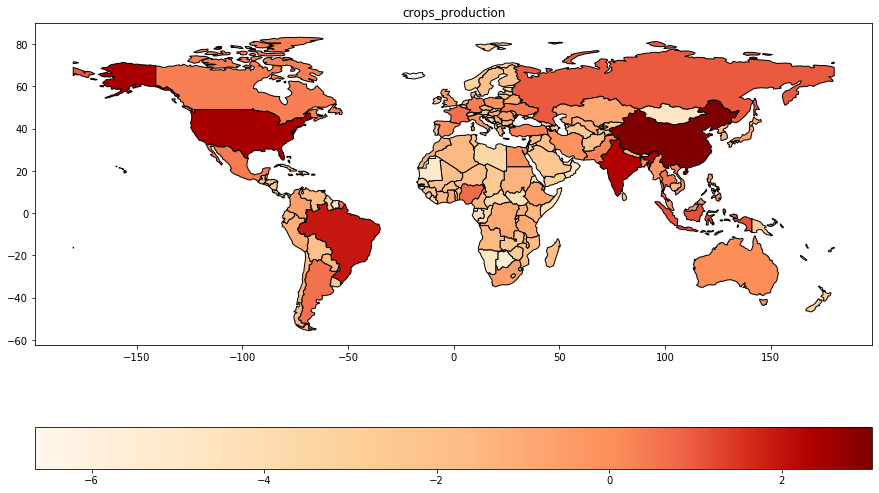

In [25]:
mapp(result,'crops_production')

We then define the funciton clean_df that does the cleaning we have seen so far. **we save the function in the file helpers.py**

In [26]:
def clean_df(df,years,to_drop,changes):
    df= df.replace(changes)
    df = df.drop(years, axis=1)
    df = df.groupby('Area').sum()
    df = df.drop(to_drop, axis=1)
    to_delete = set(df.index).difference(countries)
    df = df.drop(to_delete, axis=0)
    df['tot'] = 0
    df['tot'] = df.apply(norm).sum(axis=1)
    df = df.sort_values(by=['tot'], ascending=0)
    df = df[['tot']]
    df['tot'] = df['tot']*100/max(df['tot'])
    return df

## Live Stock

We consider the dataset related to live_stock.
<br>
For this analysis we repeat, more or less the same steps of before in order to have a clear visualization of the phenomenon.

In [27]:
path = cl+'Production_LivestockPrimary_E_All_Data_NOFLAG.csv'
live_stock = pd.read_csv(path, encoding = "ISO-8859-1")

In [28]:
live_stock.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
0,2,Afghanistan,1062,"Eggs, hen, in shell",5313,Laying,1000 Head,4000.0,4400.0,4600.0,...,9100.0,8700.0,8200.0,9600.0,9500.0,9500.0,9500.0,9337.0,9369.0,10688.0
1,2,Afghanistan,1062,"Eggs, hen, in shell",5410,Yield,100mg/An,25000.0,25000.0,25000.0,...,18349.0,19285.0,19932.0,17927.0,18947.0,18947.0,19474.0,21253.0,21263.0,18713.0
2,2,Afghanistan,1062,"Eggs, hen, in shell",5510,Production,tonnes,10000.0,11000.0,11500.0,...,16698.0,16778.0,16344.0,17210.0,18000.0,18000.0,18500.0,19844.0,19921.0,20000.0
3,2,Afghanistan,1067,"Eggs, hen, in shell (number)",5513,Production,1000 No,200000.0,220000.0,230000.0,...,333960.0,335560.0,326880.0,344200.0,360000.0,360000.0,370000.0,396880.0,398420.0,400000.0
4,2,Afghanistan,919,"Hides, cattle, fresh",5320,Producing Animals/Slaughtered,Head,360000.0,384000.0,396000.0,...,739000.0,750000.0,727800.0,766700.0,772000.0,744500.0,NaN,NaN,NaN,NaN


In [29]:
live_stock_production = live_stock[live_stock['Element']=='Production']

In [30]:
#year we'd like to drop
years = ['Y'+str(1900+x) for x in range(61,100)] 
to_drop = ['Area Code','Item Code','Element Code']

In [31]:
result = clean_df(live_stock_production,years,to_drop,changes)
result.head(10)

,tot
Area,
China,100.000000
United States of America,36.566328
India,26.463457
Brazil,17.189517
Russia,10.728068
Germany,8.956105
France,7.768342
Pakistan,7.738628
Mexico,7.731026


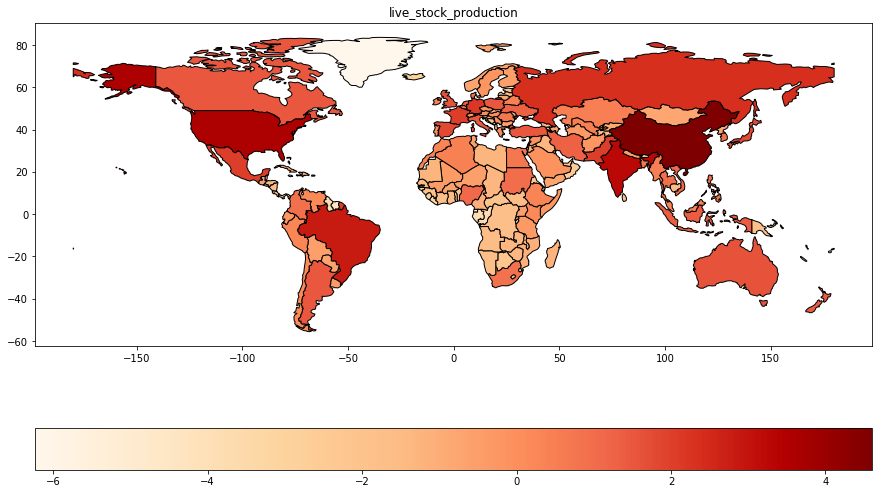

In [32]:
mapp(result,'live_stock_production')

## Production Value

In [33]:
path = cl+'Value_of_Production_E_All_Data_NOFLAG.csv'
Value_of_production = pd.read_csv(path, encoding = "ISO-8859-1")

In [34]:
Value_of_production.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y2007,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016
0,2,Afghanistan,221,"Almonds, with shell",152,Gross Production Value (constant 2004-2006 100...,1000 Int. $,NaN,NaN,NaN,...,92899.455089,123940.698000,127431.694327,165254.264000,178861.182059,182960.078000,124575.156335,80856.550600,71549.194374,96918.674867
1,2,Afghanistan,221,"Almonds, with shell",154,Net Production Value (constant 2004-2006 1000 I$),1000 Int. $,NaN,NaN,NaN,...,92899.455089,123940.698000,127431.694327,165254.264000,178861.182059,182960.078000,124575.156335,80856.550600,71549.194374,96918.674867
2,2,Afghanistan,221,"Almonds, with shell",56,Gross Production Value (current million SLC),SLC,NaN,NaN,NaN,...,5433.830473,8980.020000,8032.038000,12079.200000,13995.079900,14911.000000,9230.459191,5563.109132,4824.773367,6050.024466
3,2,Afghanistan,221,"Almonds, with shell",55,Gross Production Value (constant 2004-2006 mil...,SLC,NaN,NaN,NaN,...,3280.355179,4376.446667,4499.716581,5835.262222,6315.733546,6460.468889,4398.849906,2855.110444,2526.460140,3422.277092
4,2,Afghanistan,711,"Anise, badian, fennel, coriander",152,Gross Production Value (constant 2004-2006 100...,1000 Int. $,NaN,NaN,NaN,...,93962.672000,49744.944000,57275.009778,56377.603200,64207.463034,69090.200000,69090.200000,73114.852434,79457.968291,77478.699955


In [35]:
Value_of_production_NET = Value_of_production[Value_of_production['Element']=='Net Production Value (constant 2004-2006 1000 I$)']

In [36]:
years = ['Y'+str(1900+x) for x in range(61,100)] 

In [37]:
result = clean_df(Value_of_production_NET,years,to_drop,changes)
result.head(10)

,tot
Area,
China,100.000000
United States of America,45.308575
India,43.642346
Brazil,25.479675
Indonesia,11.208537
Russia,8.812354
France,8.583606
Argentina,7.873948
Pakistan,7.261400


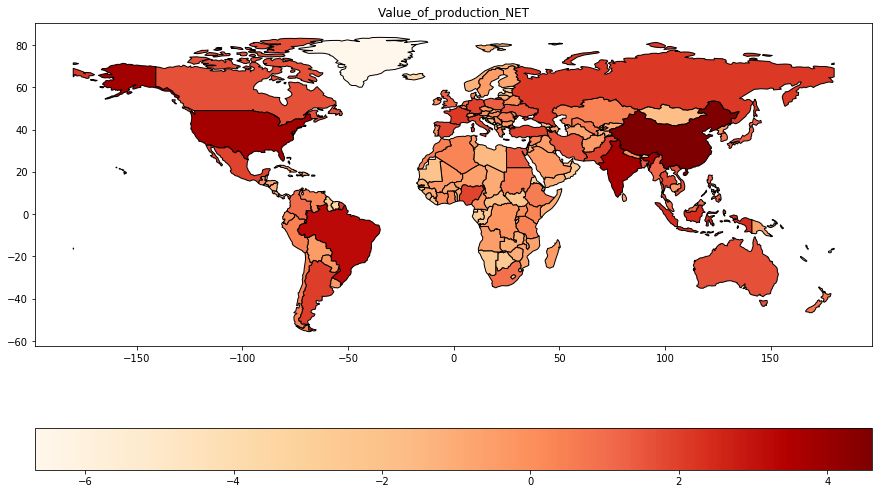

In [38]:
mapp(result,'Value_of_production_NET')

## Interactive Map

In [39]:
def interactive_df(df, changes =changes, to_drop=to_drop):
    df= df.replace(changes)
    df = df.drop(to_drop, axis=1)
    df = df.groupby('Area').sum()
    to_delete = set(df.index).difference(countries)
    df = df.drop(to_delete, axis=0)
    df = df.apply(norm)*100
    df.columns = df.columns.str.replace('Y', '')
    df = df.stack()
    df = df.reset_index()
    df = df.rename(columns={'level_1': 'YEAR', 0: 'tot'})
    df['YEAR'] = df['YEAR'].astype(int)
    return df

In [40]:
crops_production = crops[crops['Element']=='Production']
crops_production.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
2,2,Afghanistan,221,"Almonds, with shell",5510,Production,tonnes,NaN,NaN,NaN,...,42000.0,43183.0,56000.0,60611.0,62000.0,42215.0,27400.0,24246.0,32843.0,27291.0
5,2,Afghanistan,711,"Anise, badian, fennel, coriander",5510,Production,tonnes,NaN,NaN,NaN,...,9000.0,11008.0,10200.0,12508.0,12500.0,12500.0,21500.0,18000.0,18012.0,19719.0
8,2,Afghanistan,515,Apples,5510,Production,tonnes,15100.0,15100.0,15100.0,...,56061.0,72765.0,59850.0,62041.0,70000.0,78597.0,89403.0,89733.0,140903.0,175000.0
11,2,Afghanistan,526,Apricots,5510,Production,tonnes,32000.0,32000.0,32000.0,...,59559.0,60000.0,66560.0,67995.0,83500.0,90000.0,90000.0,87686.0,17894.0,131816.0
14,2,Afghanistan,44,Barley,5510,Production,tonnes,378000.0,378000.0,378000.0,...,333000.0,486000.0,437000.0,305900.0,504000.0,514000.0,521000.0,403000.0,301856.0,94995.0


In [41]:
interactive_crops = interactive_df(crops_production)

In [42]:
def interactive_df(df, changes =changes, to_drop=to_drop):
    df= df.replace(changes)
    df = df.drop(to_drop, axis=1)
    df = df.groupby('Area').sum()
    to_delete = set(df.index).difference(countries)
    df = df.drop(to_delete, axis=0)
    df = df.apply(norm)*100
    df.columns = df.columns.str.replace('Y', '')
    df = df.stack()
    df = df.reset_index()
    df = df.rename(columns={'level_1': 'YEAR', 0: 'tot'})
    df['YEAR'] = df['YEAR'].astype(int)
    return df

In [43]:
interactive_crops = interactive_df(crops_production)

In [44]:
def mapp_interactive(result, world_df=world_df):
    year = np.mean(result['YEAR'])
    result = result.drop('YEAR', axis=1)
    result['tot'] = np.log(result['tot']+10e-4)
    merged = world_df.set_index('name').join(result)
    merged = merged.dropna(subset=['tot'])
    vmin, vmax, vcenter = merged.tot.min(), merged.tot.max(), 0.1
    divnorm = colors.DivergingNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
    ax = merged.plot(column='tot', figsize=(15,10),  k=9,norm=divnorm,cmap='Greens', linewidth=1,edgecolor = "black",
                     legend=True,
                      legend_kwds={'orientation': "horizontal"})
    ax.set_title(year,size=10)
    return

In [45]:
def plot_func(year):
    result = df
    result = result.set_index('Area')
    result = result[result['YEAR']==year]
    #result = result.drop('YEAR', axis=1)
    mapp_interactive(result)

### CROPS INTERATIVE

In [46]:
df = interactive_crops
range_year = (min(df['YEAR']),max(df['YEAR']))

new = interact(plot_func,year = range_year)

interactive(children=(IntSlider(value=1989, description='year', max=2017, min=1961), Output()), _dom_classes=(…

### LIVE STOCK INTERACTIVE

In [47]:
interactive_live_stock = interactive_df(live_stock_production)

In [48]:
df = interactive_live_stock
range_year = (min(df['YEAR']),max(df['YEAR']))
interact(plot_func,year = range_year)


interactive(children=(IntSlider(value=1989, description='year', max=2017, min=1961), Output()), _dom_classes=(…

<function __main__.plot_func(year)>

### INTERACTIVE AGRICULTURAL VALUES

In [49]:
interactiove_values = interactive_df(Value_of_production_NET)

In [50]:
df = interactiove_values
range_year = (min(df['YEAR']),max(df['YEAR']))
interact(plot_func,year = range_year)


interactive(children=(IntSlider(value=1988, description='year', max=2016, min=1961), Output()), _dom_classes=(…

<function __main__.plot_func(year)>

# Total emissions in agriculture
In this part of the mileston we anlayze the total emissions in agriculture dataset from [FAO](http://www.fao.org/faostat/en/#data/GT) 

In [51]:
# Importa the dataset
eat=pd.read_csv(en+EAT,encoding = "ISO-8859-1")

In [52]:
# See how it is organized
print(eat.columns)
eat.head()

Index(['Area Code', 'Area', 'Item Code', 'Item', 'Element Code', 'Element',
       'Unit', 'Y1961', 'Y1962', 'Y1963', 'Y1964', 'Y1965', 'Y1966', 'Y1967',
       'Y1968', 'Y1969', 'Y1970', 'Y1971', 'Y1972', 'Y1973', 'Y1974', 'Y1975',
       'Y1976', 'Y1977', 'Y1978', 'Y1979', 'Y1980', 'Y1981', 'Y1982', 'Y1983',
       'Y1984', 'Y1985', 'Y1986', 'Y1987', 'Y1988', 'Y1989', 'Y1990', 'Y1991',
       'Y1992', 'Y1993', 'Y1994', 'Y1995', 'Y1996', 'Y1997', 'Y1998', 'Y1999',
       'Y2000', 'Y2001', 'Y2002', 'Y2003', 'Y2004', 'Y2005', 'Y2006', 'Y2007',
       'Y2008', 'Y2009', 'Y2010', 'Y2011', 'Y2012', 'Y2013', 'Y2014', 'Y2015',
       'Y2016', 'Y2017', 'Y2030', 'Y2050'],
      dtype='object')


,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Y2030,Y2050
0,2,Afghanistan,5058,Enteric Fermentation,7225,Emissions (CH4),gigagrams,240.6831,245.3106,255.8285,...,401.0680,402.5130,396.9210,393.0930,398.2870,384.1370,381.6789,371.9253,453.7474,603.6185
1,2,Afghanistan,5058,Enteric Fermentation,7231,Emissions (CO2eq),gigagrams,5054.3459,5151.5228,5372.3989,...,8422.4280,8452.7730,8335.3410,8254.9530,8364.0270,8066.8761,8015.2578,7810.4313,9528.6962,12675.9880
2,2,Afghanistan,5058,Enteric Fermentation,7244,Emissions (CO2eq) from CH4,gigagrams,5054.3459,5151.5228,5372.3989,...,8422.4280,8452.7730,8335.3410,8254.9530,8364.0270,8066.8761,8015.2578,7810.4313,9528.6962,12675.9880
3,2,Afghanistan,5059,Manure Management,7225,Emissions (CH4),gigagrams,11.6228,11.9632,12.6064,...,26.5669,26.1599,26.0913,26.0859,26.3682,24.9017,24.7679,23.7619,27.2114,35.2700
4,2,Afghanistan,5059,Manure Management,7231,Emissions (CO2eq),gigagrams,367.8310,376.4362,392.5811,...,681.2759,678.8488,672.3300,667.6991,675.6191,645.1936,641.9611,623.3735,750.3240,1003.2279


In [53]:
# See the unique values of the interesting columns
def uniquevalues(df):
    for i in ['Item', 'Element', 'Unit']:
        print(i)
        print(df[i].unique())
uniquevalues(eat)

Item
['Enteric Fermentation' 'Manure Management' 'Rice Cultivation'
 'Synthetic Fertilizers' 'Manure applied to Soils'
 'Manure left on Pasture' 'Crop Residues' 'Burning - Crop residues'
 'Burning - Savanna' 'Agriculture total' 'Agricultural Soils'
 'Cultivation of Organic Soils']
Element
['Emissions (CH4)' 'Emissions (CO2eq)' 'Emissions (CO2eq) from CH4'
 'Emissions (CO2eq) from N2O' 'Emissions (N2O)']
Unit
['gigagrams']


As we can see from the Element column, we have different emissions measurements. Among all we have the column Emissions (CO2eq) that is actually the sum of all the emissions converted into equivalent CO2 production. Therefore we decidde to keep only these values.

In [54]:
# Keep only the CO2 equivalent values
eat = eat[eat.Element=='Emissions (CO2eq)']

Considering the Item column, we can see that the emission production can be referred to different specific agriculture topics. We notice that we could specifically refer them to livestock or crop production. Therefore we dicide to split the dataset into two different datasets.

The dataset 'eat_live_stock' contains the emssions referred to:
    - 'Enteric Fermentation'
    - 'Manure Management'
    - 'Manure left on Pature'
The dataset 'eat_agricuture' contains the emissions referred to:
    - 'Synthetic Fertilizers'
    - 'Manure applied to Soils'
    - 'Crop Residues'
    - 'Burning - Crop residues'
    - 'Burning - Savanna'
    - 'Rice Cultivation'
    - 'Cultivation of Organic Soils'

In [55]:
# Create the livestock emissions dataset
eat_live_stock = eat[(eat.Item=='Enteric Fermentation')\
                     | (eat.Item=='Manure Management')\
                     | (eat.Item=='Manure left on Pasture')]

In [56]:
# Create the crops emissions dataset
eat_crop = eat[(eat.Item=='Synthetic Fertilizers')\
                     | (eat.Item=='Manure applied to Soils')\
                     | (eat.Item=='Crop Residues')\
                     | (eat.Item=='Burning - Crop residues')\
                     | (eat.Item=='Burning - Savanna')\
                     | (eat.Item=='Rice Cultivation')\
                     | (eat.Item=='Cultivation of Organic Soils')]

As previously done for the agriculture production datasets we select only the years of interest. For this dataset we also have predictions for the emissions in 2030 and 2050. We decide to keep them as they might be useful for further analyses.

In [57]:
# Drop the columns of years before 2000
years = ['Y'+str(1900+x) for x in range(61,100)]+ ['Y2030','Y2050']
to_drop = ['Area Code','Item Code','Element Code']

We then use the previously defined funciton 'clean_df' that we use to clean the datasets.

In [58]:
result = clean_df(eat_live_stock,years,to_drop,changes)

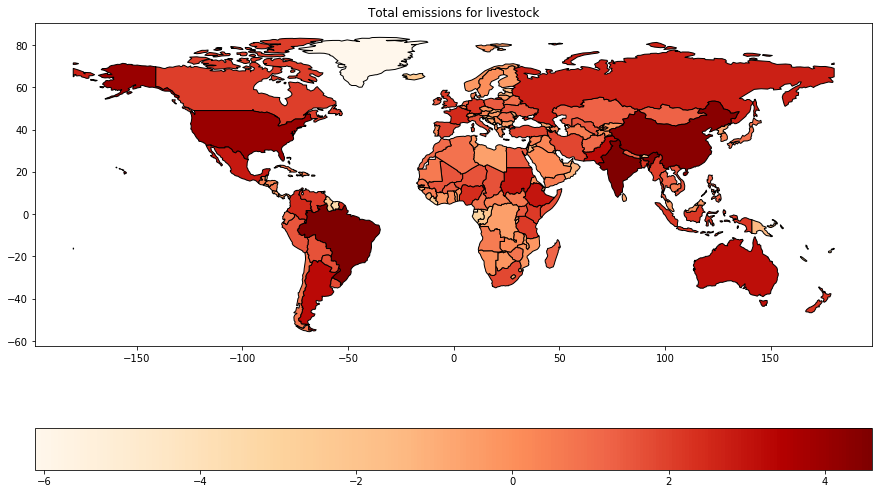

In [59]:
mapp(result, 'Total emissions for livestock')

In [60]:
result = clean_df(eat_crop,years,to_drop,changes)

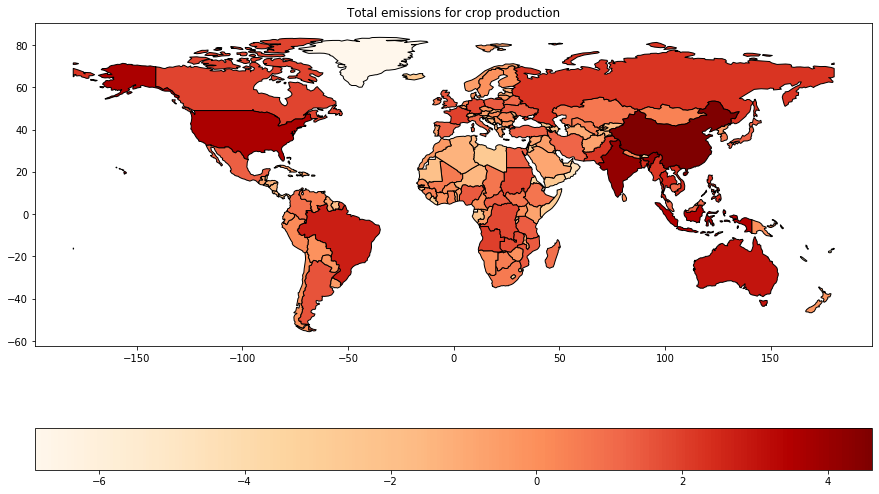

In [61]:
mapp(result, 'Total emissions for crop production')

In [62]:
eat_live_stock_interactive = interactive_df(eat_live_stock)

In [63]:
df = eat_live_stock_interactive
range_year = (min(df['YEAR']),max(df['YEAR']))
interact(plot_func,year = range_year)


interactive(children=(IntSlider(value=2005, description='year', max=2050, min=1961), Output()), _dom_classes=(…

<function __main__.plot_func(year)>

In [64]:
eat_crop_interactive = interactive_df(eat_crop)

In [65]:
df = eat_crop_interactive
range_year = (min(df['YEAR']),max(df['YEAR']))
interact(plot_func,year = range_year)


interactive(children=(IntSlider(value=2005, description='year', max=2050, min=1961), Output()), _dom_classes=(…

<function __main__.plot_func(year)>

In [66]:
interactive_crops = interactive_crops[(interactive_crops.YEAR>=1961) & (interactive_crops.YEAR<=2014)]
interactive_crops = interactive_crops.set_index(['Area','YEAR'])
complete = interactive_crops
complete['Crops'] = complete ['tot'] 
del complete['tot']

## Climate Change

In [109]:
climate_change = pd.read_csv(en+'Environment_Temperature_change_E_All_Data_NOFLAG.csv',encoding = "ISO-8859-1")

In [110]:
climate_change = climate_change[climate_change.Element=='Temperature change']
climate_change = climate_change[climate_change.Months=='Meteorological year']
climate_change.head()

,Area Code,Area,Months Code,Months,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Y2018
32,2,Afghanistan,7020,Meteorological year,7271,Temperature change,°C,-0.059,-0.154,0.820,...,1.633,1.881,1.787,0.722,1.251,1.299,1.414,1.817,1.716,2.029
66,3,Albania,7020,Meteorological year,7271,Temperature change,°C,0.656,0.318,0.072,...,0.848,0.936,0.701,1.478,1.420,1.157,1.321,1.307,0.990,1.656
100,4,Algeria,7020,Meteorological year,7271,Temperature change,°C,0.378,0.220,0.077,...,0.873,2.151,1.351,1.103,1.181,1.697,1.173,1.862,1.520,1.196
134,5,American Samoa,7020,Meteorological year,7271,Temperature change,°C,-0.085,-0.188,-0.024,...,0.999,NaN,0.582,0.496,0.822,0.819,0.563,1.079,0.988,0.738
168,6,Andorra,7020,Meteorological year,7271,Temperature change,°C,0.691,0.107,-0.719,...,1.443,0.459,1.744,1.357,0.779,1.958,1.547,1.825,1.774,1.822


In [67]:
def for_complete(df,complete,name):
    df = df[(df.YEAR>=1961) | (df.YEAR<=2014)]
    df = df.set_index(['Area','YEAR'])
    complete[name] = df ['tot'] 
    return complete

In [68]:
l = [interactive_live_stock,interactiove_values,eat_live_stock_interactive,eat_crop_interactive]
l_name = ['Live_stock','Agricultural_values','Eat_live_stock','Eat_crop']

In [69]:
for i in range(len(l)):
    complete = for_complete(l[i],complete,l_name[i])

In [70]:
complete = complete.reset_index()

In [71]:
complete.to_pickle("./complete.pkl")

In [72]:
complete = complete.rename(columns={"YEAR":"Year"})

In [97]:
def plot_func(countries,features):
    countries = list(countries)
    features = list(features)
    plot = compare_different_country(complete, country=countries, feature=features, plot=True)
    return

In [98]:
f = list(complete.columns)
f.remove('Area')
f.remove('Year')
c1=set(['China', 'United States of America', 'India', 'Brazil', 'Indonesia',
       'Russia', 'Nigeria', 'France', 'Argentina', 'Thailand'])
c2=set(['China', 'United States of America', 'India', 'Brazil', 'Russia',
       'Germany', 'France', 'Pakistan', 'Mexico', 'Spain'])
c = list(c1.union(c2))

In [108]:
s_c = SelectMultiple(options=c,description='country',rows=len(c),layout=Layout(width="100%"))
s_f = SelectMultiple(options=f)
other_widget.selected_labels = ()

def update_other(*args):

    other_widget.value = ()
    other_widget.selected_labels = ()
    other_widget.options = list(set(select_widget.options).difference(set([select_widget.value])))

select_widget.observe(update_other)

interact(plot_func, countries= s_c , features = s_f)

interactive(children=(SelectMultiple(description='country', layout=Layout(width='100%'), options=('Germany', '…

<function __main__.plot_func(countries, features)>